In [7]:
# Importations
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import torch

# Graine aléatoire pour reproductibilité
np.random.seed(42)
torch.manual_seed(42)
print("Bibliothèques chargées avec succès !")

Bibliothèques chargées avec succès !


In [8]:
# Load files
train_edges = pd.read_csv('data/train.txt', sep=' ', header=None, names=['node1', 'node2'])
test_pairs = pd.read_csv('data/test.txt', sep=' ', header=None, names=['node1', 'node2'])
node_features = pd.read_csv('data/node_information.csv')
sample_submission = pd.read_csv('data/random_predictions.csv')

# Preview the data
print("Preview of node_information.csv:")
print(node_features.head())

print("\nPreview of train.txt:")
print(train_edges.head())

print("\nPreview of test.txt:")
print(test_pairs.head())

# Build the graph
G = nx.from_pandas_edgelist(train_edges, 'node1', 'node2')

# Assume first column is the node identifier
id_column = node_features.columns[0]  # Adjust if needed after inspection
feature_cols = [col for col in node_features.columns if col != id_column]
X = torch.tensor(node_features[feature_cols].values, dtype=torch.float)
node_id_map = {id: idx for idx, id in enumerate(node_features[id_column])}

# Ensure consistent node types and mapping
train_edges['node1'] = train_edges['node1'].astype(int)
train_edges['node2'] = train_edges['node2'].astype(int)
node_features[id_column] = node_features[id_column].astype(int)

# Create mapping to ensure all nodes are covered
node_id_map = {id: idx for idx, id in enumerate(node_features[id_column])}

# Check unmapped nodes
train_nodes = set(train_edges['node1']).union(set(train_edges['node2']))
mapped_nodes = set(node_id_map.keys())
unmapped_nodes = train_nodes - mapped_nodes

print("Unmapped nodes:", unmapped_nodes)

# Basic node statistics
node_ids = set(node_id_map.keys())
print(f"\nNodes in train.txt: {len(train_nodes)}")
print(f"Nodes in node_information.csv: {len(node_ids)}")
print(f"Common nodes: {len(train_nodes.intersection(node_ids))}")

# Graph info
print(f"\nNumber of nodes in the graph: {G.number_of_nodes()}")
print(f"Number of edges in train set: {G.number_of_edges()}")
print(f"Number of pairs to predict: {len(test_pairs)}")
print(f"Feature dimension: {X.shape[1]}")
print(f"ID column used: {id_column}")

Preview of node_information.csv:
   0  0.0  0.0.1  0.0.2  0.0.3  0.0.4  0.0.5  0.0.6  0.0.7  0.0.8  ...  \
0  4  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
1  5  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
2  6  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
3  7  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
4  9  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   

   0.0.911  0.0.912  0.0.913  0.0.914  0.0.915  0.0.916  0.0.917  0.0.918  \
0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   0.0.919  0.0.920  
0      0.0      0.0  
1      0.0     

In [9]:
non_zero_counts = (node_features.drop(columns=[id_column]) != 0).sum()
print(f"Features non-nulles : {(non_zero_counts > 0).sum()} / {len(non_zero_counts)}")

Features non-nulles : 929 / 932


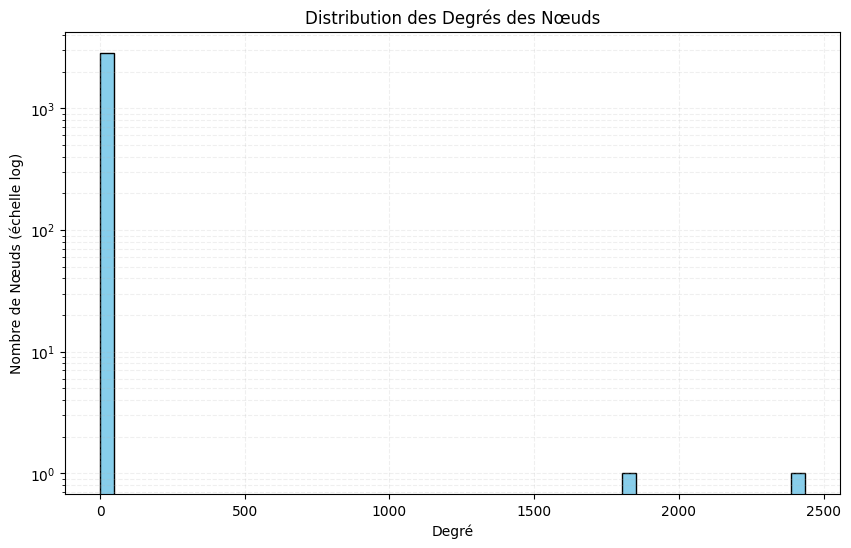

Cette visualisation montre la répartition des degrés, utile pour identifier les hubs.


In [10]:
# Calcul des degrés
degrees = [d for n, d in G.degree()]

# Histogramme des degrés
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50, log=True, color='skyblue', edgecolor='black')
plt.title("Distribution des Degrés des Nœuds")
plt.xlabel("Degré")
plt.ylabel("Nombre de Nœuds (échelle log)")
plt.grid(True, which="both", ls="--", alpha=0.2)
plt.show()

print("Cette visualisation montre la répartition des degrés, utile pour identifier les hubs.")

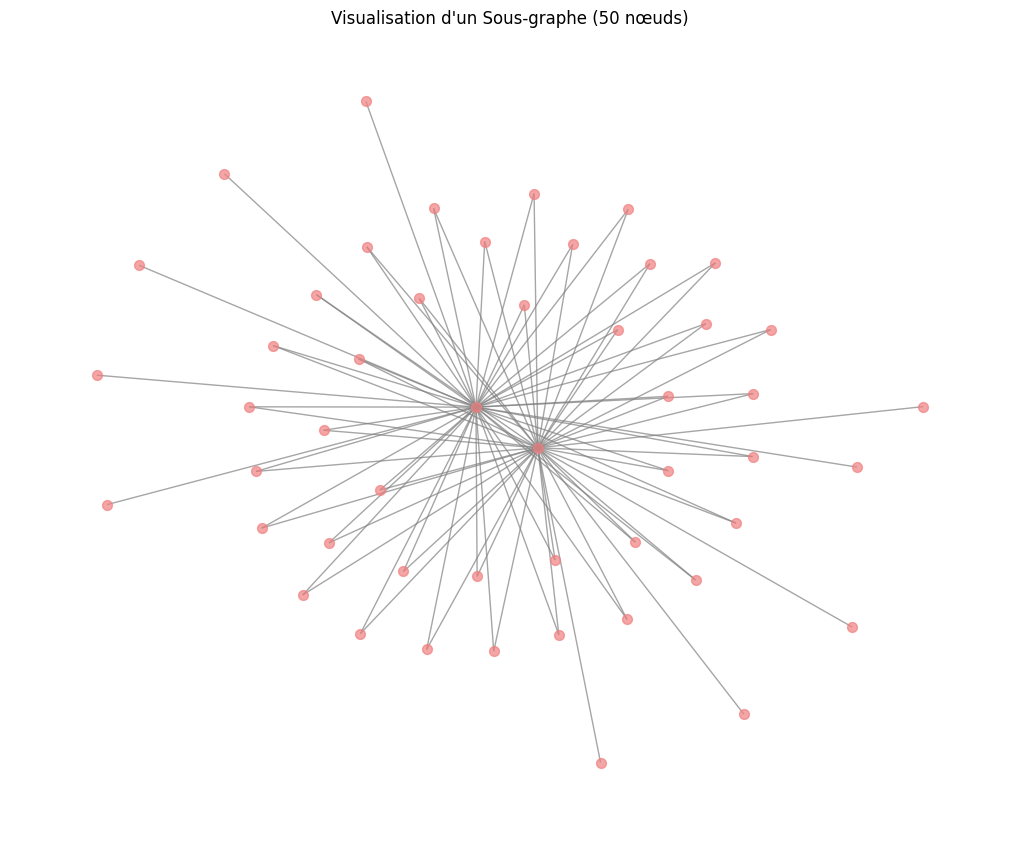

Ce sous-graphe donne un aperçu de la structure locale du réseau.


In [11]:
# Extraction d'un petit sous-graphe (50 premiers nœuds)
subgraph_nodes = list(G.nodes())[:50]
subG = G.subgraph(subgraph_nodes)

# Dessin du sous-graphe
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subG, seed=42)
nx.draw(subG, pos, node_size=50, node_color='lightcoral', with_labels=False, edge_color='gray', alpha=0.7)
plt.title("Visualisation d'un Sous-graphe (50 nœuds)")
plt.show()

print("Ce sous-graphe donne un aperçu de la structure locale du réseau.")

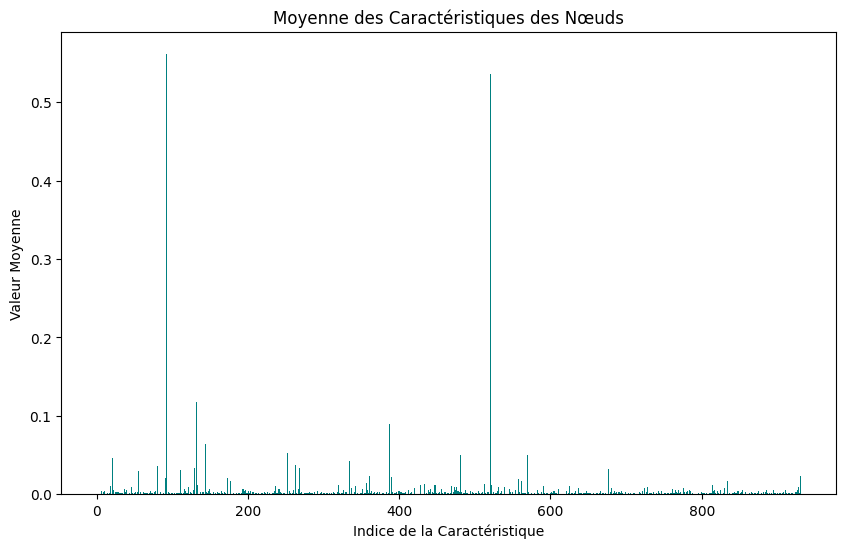

Cet histogramme montre la distribution des valeurs moyennes des caractéristiques.


In [12]:
# Moyenne des caractéristiques par nœud
mean_features = X.mean(dim=0).numpy()

# Histogramme
plt.figure(figsize=(10, 6))
plt.bar(range(len(mean_features)), mean_features, color='teal')
plt.title("Moyenne des Caractéristiques des Nœuds")
plt.xlabel("Indice de la Caractéristique")
plt.ylabel("Valeur Moyenne")
plt.show()

print("Cet histogramme montre la distribution des valeurs moyennes des caractéristiques.")

In [13]:
# Fonction pour calculer l'indice Adamic-Adar
def compute_adamic_adar(G, pairs):
    preds = []
    for u, v in pairs:
        if u in G and v in G:
            score = sum(1 / np.log(G.degree(w)) for w in nx.common_neighbors(G, u, v) if G.degree(w) > 1)
            preds.append(score if score > 0 else 0)
        else:
            preds.append(0)
    return preds

# Prédictions baseline pour les paires de test
test_node_pairs = test_pairs[['node1', 'node2']].values
baseline_preds = compute_adamic_adar(G, test_node_pairs)
baseline_preds = np.array(baseline_preds) / (np.max(baseline_preds) + 1e-10)  # Normalisation
print("Prédictions baseline calculées.")

Prédictions baseline calculées.


In [14]:
# Check node_id_map
print("node_id_map contents:")
print(node_id_map)
print("Number of nodes in node_id_map:", len(node_id_map))

# Check original graph
print("Total number of edges in original graph:", len(G.edges()))
print("Total number of nodes in original graph:", len(G.nodes()))

# Verify edge mapping
print("Sample edges:")
for u, v in list(G.edges())[:5]:
    print(f"Edge: {u} - {v}")
    print(f"Mapped nodes: {node_id_map.get(u, 'Not found')} - {node_id_map.get(v, 'Not found')}")

node_id_map contents:
{4: 0, 5: 1, 6: 2, 7: 3, 9: 4, 10: 5, 11: 6, 13: 7, 17: 8, 19: 9, 20: 10, 23: 11, 24: 12, 25: 13, 26: 14, 27: 15, 28: 16, 30: 17, 32: 18, 33: 19, 36: 20, 37: 21, 38: 22, 39: 23, 40: 24, 46: 25, 49: 26, 51: 27, 52: 28, 53: 29, 55: 30, 60: 31, 61: 32, 62: 33, 64: 34, 67: 35, 69: 36, 70: 37, 72: 38, 74: 39, 75: 40, 79: 41, 80: 42, 81: 43, 84: 44, 86: 45, 87: 46, 88: 47, 89: 48, 90: 49, 92: 50, 93: 51, 94: 52, 96: 53, 97: 54, 98: 55, 99: 56, 103: 57, 104: 58, 105: 59, 106: 60, 107: 61, 108: 62, 109: 63, 114: 64, 117: 65, 119: 66, 125: 67, 127: 68, 130: 69, 132: 70, 133: 71, 137: 72, 138: 73, 139: 74, 141: 75, 142: 76, 144: 77, 147: 78, 148: 79, 150: 80, 151: 81, 153: 82, 154: 83, 156: 84, 157: 85, 158: 86, 159: 87, 160: 88, 161: 89, 162: 90, 164: 91, 165: 92, 166: 93, 171: 94, 173: 95, 174: 96, 175: 97, 178: 98, 179: 99, 180: 100, 182: 101, 184: 102, 185: 103, 186: 104, 187: 105, 188: 106, 189: 107, 190: 108, 191: 109, 195: 110, 196: 111, 197: 112, 202: 113, 207: 114,